In [1]:
import numpy as np
import pandas as pd
from scipy.stats import gamma
import socceraction
import socceraction.spadl as spadl
import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from mplsoccer import FontManager
from adjustText import adjust_text

In [2]:
fe = fm.FontEntry(
    fname='/Users/davidegualano/Documents/Python FTBLData/SourceSansPro-Regular.ttf',
    name='SourceSansPro-Regular'
)
fm.fontManager.ttflist.insert(0, fe)
matplotlib.rcParams['font.family'] = fe.name

In [3]:
xG = pd.read_csv("xGactions.csv", index_col = 0)

teams0 = pd.read_csv("teams2021.csv", index_col = 0)
teams1 = pd.read_csv("teams2122.csv", index_col = 0)
teams2 = pd.read_csv("teams2223.csv", index_col = 0)
teams3 = pd.read_csv("teams2324.csv", index_col = 0)

players0 = pd.read_csv("players2021.csv", index_col = 0)
players1 = pd.read_csv("players2122.csv", index_col = 0)
players2 = pd.read_csv("players2223.csv", index_col = 0)
players3 = pd.read_csv("players2324.csv", index_col = 0)

games0 = pd.read_csv("games2021.csv", index_col = 0)
games1 = pd.read_csv("games2122.csv", index_col = 0)
games2 = pd.read_csv("games2223.csv", index_col = 0)
games3 = pd.read_csv("games2324.csv", index_col = 0)

actions0 = pd.read_csv("actions2021.csv", index_col = 0)
actions1 = pd.read_csv("actions2122.csv", index_col = 0)
actions2 = pd.read_csv("actions2223.csv", index_col = 0)
actions3 = pd.read_csv("actions2324.csv", index_col = 0)

In [4]:
teams = pd.concat([teams0, teams1, teams2, teams3])
players = pd.concat([players0, players1, players2, players3])
games = pd.concat([games0, games1, games2, games3])
actions = pd.concat([actions0, actions1, actions2, actions3])

In [5]:
actions.drop(columns=['action_id'], inplace=True)
actions.reset_index(drop=True, inplace=True)
actions.reset_index(inplace=True)
actions.rename(columns={'index': 'action_id'}, inplace=True)

In [6]:
teams = teams.drop_duplicates()

In [7]:
actions = spadl.add_names(actions)

In [8]:
df = (
    actions
    .merge(players, how="left")
    .merge(teams, how="left")
    .merge(xG, how="left")
    .merge(games, how="left"))

In [9]:
df1 = df[df["type_name"] == 'shot']

In [10]:
df1['date'] = pd.to_datetime(df1['game_date']).dt.date

# Convert the 'date_only' column back to datetime if needed
df1['date'] = pd.to_datetime(df1['date'])

/var/folders/ns/3wxdg4g57h77vxwmr4wzmvt40000gn/T/ipykernel_75315/1087720334.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['date'] = pd.to_datetime(df1['game_date']).dt.date
/var/folders/ns/3wxdg4g57h77vxwmr4wzmvt40000gn/T/ipykernel_75315/1087720334.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['date'] = pd.to_datetime(df1['date'])


In [11]:
# Example time decay function (exponential decay)
def calculate_decay_weight(dates, current_date, decay_rate=0.05):
    days_since = (current_date - dates).dt.days
    return np.exp(-decay_rate * days_since)

# Assuming 'date' column exists in df1
current_date = df1['date'].max()

# Add a decay weight to df1 based on the date
df1['decay_weight'] = calculate_decay_weight(df1['date'], current_date)

/var/folders/ns/3wxdg4g57h77vxwmr4wzmvt40000gn/T/ipykernel_75315/2984167161.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['decay_weight'] = calculate_decay_weight(df1['date'], current_date)


In [12]:
Y = (df1.groupby(["player_name", 'team_name', "competition_id", "season_id"], observed = True)["type_name"].count().reset_index())
Y.rename(columns = {'type_name':'shots'}, inplace = True)

df2 = df1[df1["result_name"] != "fail"]
X = (df2.groupby(["player_name", 'team_name', "competition_id", "season_id"], observed = True)["type_name"].count().reset_index())
X.rename(columns = {'type_name':'goals'}, inplace = True)

Z = (df1.groupby(["player_name", 'team_name', "competition_id", "season_id"], observed = True)["xG"].sum().reset_index())

Time = (df1.groupby(["player_name", "team_name", "competition_id", "season_id", "game_id", "starting_position"], observed = True)["minutes_played"].mean().reset_index())
T = Time[Time["starting_position"] != 'Sub']
T = T.drop_duplicates(subset=['player_name', 'team_name', "competition_id", "season_id"])
T1 = (Time.groupby(["player_name", "team_name", "competition_id", "season_id"], observed = True)["minutes_played"].sum().reset_index())
T2 = (T.groupby(["player_name", "team_name", "competition_id", "season_id", "starting_position"], observed = True)["minutes_played"].sum().reset_index())
T2 = T2.filter(items=["player_name", "team_name", "competition_id", "season_id", "starting_position"])
T0 = (T1.merge(T2, how="left"))

In [13]:
A = (Y
    .merge(X, how="left")
    .merge(Z, how="left")
    .merge(T0, how="left"))

A1 = A.filter(items=["player_name", "shots", "goals", "xG", "starting_position"])

A2 = A1.groupby('player_name').agg({
    'shots': 'sum',
    'goals': 'sum',
    'xG': 'sum',
    'starting_position': 'first'  # Keep the first non-null starting position
}).reset_index()

In [14]:
A2['goals'] = A2['goals'].fillna(0)
A2['goals'] = A2['goals'].astype(int)
A2['raw_ratio'] = A2['goals'] / A2['xG']
Ba = A2[(A2['shots'] >= 100) & (A2['goals'] > 0)]

In [15]:
# Calculate weighted goals and xG for each event
df1['goals'] = df1['result_name'].apply(lambda x: 1 if x != "fail" else 0)
df1['weighted_xG'] = df1['xG'] * np.exp(df1['decay_weight'])

# Now, aggregate these weighted values at the player level
weighted_agg = df1.groupby(["player_name", 'team_name', "competition_id", "season_id"], observed=True).agg({
    'goals': 'sum',
    'weighted_xG': 'sum',
    'type_name': 'count'  # This counts the number of shots
}).reset_index()

# Rename columns for clarity
weighted_agg.rename(columns={'type_name': 'shots'}, inplace=True)

Ab = (weighted_agg.merge(T0, how="left"))
Ac = Ab.filter(items=["player_name", "shots", "goals", "weighted_xG", "starting_position"])

Ad = Ac.groupby('player_name').agg({
    'shots': 'sum',
    'goals': 'sum',
    'weighted_xG': 'sum',
    'starting_position': 'first'  # Keep the first non-null starting position
}).reset_index()

Ad['goals'] = Ad['goals'].fillna(0)
Ad['goals'] = Ad['goals'].astype(int)
Ad['weighted_raw_ratio'] = Ad['goals'] / Ad['weighted_xG']

/var/folders/ns/3wxdg4g57h77vxwmr4wzmvt40000gn/T/ipykernel_75315/203357294.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['goals'] = df1['result_name'].apply(lambda x: 1 if x != "fail" else 0)
/var/folders/ns/3wxdg4g57h77vxwmr4wzmvt40000gn/T/ipykernel_75315/203357294.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['weighted_xG'] = df1['xG'] * np.exp(df1['decay_weight'])


In [19]:
Ba = A2.merge(Ad, how="left")
B = Ba[(Ba['shots'] >= 100) & (Ba['goals'] > 0)]

In [20]:
playerlist = Bb['player_name'].unique().tolist()
cleaned_playerlist = [name for name in playerlist if pd.notna(name)]
cleaned_playerlist.sort()

In [21]:
def simulate_gamma_posterior(successes, trials, prior_shape, prior_rate, n_sims=10000, seed=42):
    np.random.seed(seed)
    posterior_shape = prior_shape + successes
    posterior_rate = prior_rate + trials
    posterior_sample = np.random.gamma(posterior_shape, 1/posterior_rate, n_sims)
    return {
        'mean': np.mean(posterior_sample),
        'sd': np.std(posterior_sample)
    }

# Ensure there is data after filtering; if not, handle the case
if not Bb.empty:
    # Fit the gamma distribution to the weighted ratio (weighted_goals / weighted_xG)
    shape, loc, scale = gamma.fit(B['weighted_raw_ratio'], floc=0)
    prior_shape = shape
    prior_rate = 1 / scale

    print(f"Prior shape: {round(prior_shape, 2)}, Prior rate: {round(prior_rate, 2)}")

    # Apply the function using weighted goals and xG
    B['adj_ratio'] = B.apply(
        lambda row: simulate_gamma_posterior(row['goals'], row['weighted_xG'], prior_shape, prior_rate),
        axis=1
    )

    # Unnest the adj_ratio column
    adj_ratio_df = B['adj_ratio'].apply(pd.Series)
    B = pd.concat([B, adj_ratio_df], axis=1)

    # Rename columns for clarity
    B = B.rename(columns={'mean': 'adj_ratio_mean', 'sd': 'adj_ratio_sd'})

    # Sort the DataFrame by adjusted ratio mean
    C = B.sort_values(by='adj_ratio_mean', ascending=False)

Prior shape: 16.31, Prior rate: 15.76


/var/folders/ns/3wxdg4g57h77vxwmr4wzmvt40000gn/T/ipykernel_75315/683524329.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  B['adj_ratio'] = B.apply(


In [22]:
from IPython.display import display, HTML

# Step 3: Generate the HTML dropdown
options_html = ''.join([f'<option value="{name}">{name}</option>' for name in cleaned_playerlist])

dropdown_html = f"""
<input list="players" id="dropdown" oninput="handleInput()" placeholder="Choose Someone">
<datalist id="players">
    {options_html}
</datalist>
<p id="output"></p>
<script>
function handleInput() {{
    var input = document.getElementById("dropdown").value;
    var output = document.getElementById("output");
    output.innerHTML = "Selected: " + input;
}}
</script>
"""

# Display the dropdown
display(HTML(dropdown_html))

In [43]:
player_names = ['Rafael Leão', 'Vinícius Júnior', 'Kylian Mbappé', 'Khvicha Kvaratskhelia', 'Federico Chiesa', 'Luis Díaz', 'Cody Gakpo']
Cc = C[C['player_name'].isin(player_names)]
Cc

,player_name,shots,goals,xG,starting_position,raw_ratio,weighted_xG,weighted_raw_ratio,adj_ratio,adj_ratio_mean,adj_ratio_sd
7241,Kylian Mbappé,618,115,83.254111,FW,1.381313,84.011015,1.368868,"{'mean': 1.318309207395497, 'sd': 0.1140084243...",1.318309,0.114008
3896,Federico Chiesa,229,28,21.113437,DMR,1.326170,22.302178,1.255483,"{'mean': 1.1673245255250964, 'sd': 0.173634581...",1.167325,0.173635
2283,Cody Gakpo,323,50,42.256839,FW,1.183240,43.177035,1.158023,"{'mean': 1.1276083824718197, 'sd': 0.137143833...",1.127608,0.137144
10536,Rafael Leão,360,48,42.419751,AML,1.131548,44.320056,1.083031,"{'mean': 1.0728244299115093, 'sd': 0.132496274...",1.072824,0.132496
7816,Luis Díaz,398,50,46.468703,MR,1.075993,47.027839,1.063200,"{'mean': 1.0584480076258236, 'sd': 0.128732297...",1.058448,0.128732
12779,Vinícius Júnior,385,63,59.393715,AML,1.060718,61.790862,1.019568,"{'mean': 1.0247935744621266, 'sd': 0.113987151...",1.024794,0.113987
7044,Khvicha Kvaratskhelia,341,26,29.266365,AML,0.888392,29.827139,0.871689,"{'mean': 0.9306832539311252, 'sd': 0.141675296...",0.930683,0.141675


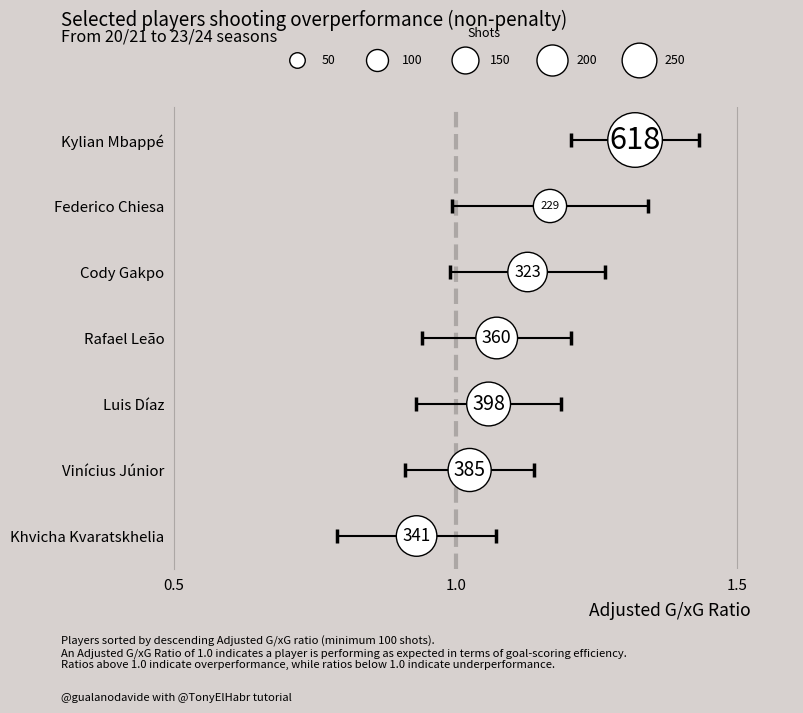

In [53]:
# Assuming C is the DataFrame with adjusted ratios and player_name
# Filter the top 10 players by adjusted goal-scoring ratio mean
D = Cc.head(20)

fig = plt.figure(figsize = (8, 6), facecolor = '#D7D1CF')
ax = plt.subplot(111, facecolor = '#D7D1CF')

# Remove the bottom spine of the x-axis
ax.spines["top"].set(visible = False)
ax.spines["right"].set(visible = False)
ax.spines["bottom"].set(visible = False)
ax.spines["left"].set_color('#ACA7A5')

# Personalizzazione delle linee della griglia
ax.grid(which='major', linestyle='-', linewidth='.8', color='#ACA7A5', zorder = -1)
# Mantieni le linee della griglia per l'asse x
ax.xaxis.grid(False)
# Rimuovi le linee della griglia per l'asse y
ax.yaxis.grid(False)

# Add labels and title
ax.xaxis.set_label_text("Adjusted G/xG Ratio", size = 14, color = "#000000")
ax.yaxis.set_label_text('', size = 7, color = "#4E616C")
# Move the x-axis label
ax.xaxis.set_label_coords(0.8, -0.07)  # Move the label to the desired position (x, y)

ax.invert_yaxis()
ax.set_xlim(.5, 1.6)
ax.set_ylim(6.5, -.5)
ax.xaxis.set_major_locator(ticker.MultipleLocator(.5))
ax.tick_params(axis = 'both', labelsize = 12, color = '#D7D1CF', labelcolor = '#000000')

plt.axvline(x = 1.0, color = '#ACA7A5', linestyle = '--', linewidth = 3, zorder = 1)
plt.axvline(x = 1.5, color = '#ACA7A5', linestyle = '-', linewidth = .8, zorder = 1)

# Create the scatter plot
points = plt.scatter(
    D['adj_ratio_mean'], 
    D['player_name'],  # Use the player names directly for y-values
    s = D['shots'] * 2.5,  # Adjust size multiplier as needed
    color = '#FFFFFF', 
    edgecolor = '#000000', 
    alpha = 1,
    zorder = 3
)

# Add error bars
for index, row in D.iterrows():
    plt.errorbar(
        x = row['adj_ratio_mean'], 
        y = row['player_name'],  # Use the player names directly for y-values
        xerr = row['adj_ratio_sd'], 
        fmt = 'none', 
        ecolor = '#000000', 
        capsize = 5,
        capthick = 2.5,
        zorder = 2
    )

# Annotate the scatter points with the number of shots
for index, row in D.iterrows():
    plt.text(
        row['adj_ratio_mean'], 
        row['player_name'], 
        str(int(row['shots'])),  # The number of shots
        color = '#000000', 
        fontsize = row['shots'] * 0.04,  # Adjust the text size proportional to the scatter size
        ha = 'center', 
        va = 'center', 
        zorder = 4
    )
    
ax.text(
    x = .3, y = -1.73,
    s = "Selected players shooting overperformance (non-penalty)",
    color = "#000000",
    size = 15)
ax.text(
    x = .3, y = -1.5,
    s = "From 20/21 to 23/24 seasons",
    color = "#000000",
    size = 13)

ax.text(
    x = .3, y = 8,
    s = "Players sorted by descending Adjusted G/xG ratio (minimum 100 shots).\nAn Adjusted G/xG Ratio of 1.0 indicates a player is performing as expected in terms of goal-scoring efficiency.\nRatios above 1.0 indicate overperformance, while ratios below 1.0 indicate underperformance.",
    color = "#000000",
    size = 9)
ax.text(
    x = .3, y = 8.5,
    s = "Twitter : @gualanodavide | Bluesky : @gualanodavide.bsky.social (with @TonyElHabr tutorial)",
    color = "#000000",
    size = 9)

# Custom legend
legend_sizes = [50, 100, 150, 200, 250]
for size in legend_sizes:
    plt.scatter([], [], s = size * 2.5, color = '#FFFFFF', edgecolor = '#000000', alpha = 1, label = str(size))
# Position the legend horizontally over the upper spine
plt.legend(scatterpoints = 1, frameon = False, labelspacing = 1, title = 'Shots',
           loc = 'upper center', bbox_to_anchor = (0.5, 1.2), ncol = len(legend_sizes))

plt.savefig('ScoringOverperformance.png', dpi=300, bbox_inches = "tight")

# Explanation

**Adjusted G/xG Ratio:** This ratio is calculated using a Bayesian approach, where the posterior distribution of the player’s goals per expected goals (G/xG) is estimated using a gamma distribution. This helps to account for variability and uncertainty in the player’s performance, especially for players with fewer shots.

**Scatter Plot Points:** The size of each scatter plot point represents the number of shots taken by the player. Larger points indicate more shots, which typically means more reliable estimates of their shooting performance. The position of each point on the x-axis represents the player’s adjusted G/xG ratio, which is an estimate of their goal-scoring efficiency after adjusting for variability.

**Error Bars:** The error bars around each point represent the range of uncertainty in the player’s adjusted G/xG ratio. They are derived from the standard deviation of the posterior distribution. These bars indicate the confidence interval for the player’s true shooting ability, with wider bars indicating more uncertainty and narrower bars indicating more precision.

**Adjusted G/xG Ratio Calculation**

**Raw Ratio Calculation:** The raw G/xG ratio is calculated as goals / xG.

**Prior Distribution:** A gamma distribution is fitted to the raw ratios of players with a substantial number of shots (e.g., minimum 50 shots) to establish a prior distribution. This helps to inform the posterior distribution.

**Posterior Distribution:** The adjusted G/xG ratio is derived from the posterior distribution, which combines the prior distribution with the player’s observed data (number of goals and expected goals). This Bayesian approach helps to mitigate the effect of small sample sizes and extreme values.